In [1]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection._split import train_test_split
from skater.core.visualizer.tree_visualizer import plot_tree, tree_to_text
from skater.util.dataops import show_in_notebook

import numpy as np
import pandas as pd

In [2]:
X, y = make_moons(1000, noise=0.5)

X = pd.DataFrame(X, columns=['F1', 'F2'])
print(np.unique(y))
print(X.columns)
print("*List the feature type* \n", X.dtypes)
X.head()

[0 1]
Index(['F1', 'F2'], dtype='object')
*List the feature type* 
 F1    float64
F2    float64
dtype: object


,F1,F2
0,1.390426,0.299731
1,-1.242828,1.179965
2,1.365143,-0.263511
3,0.662827,0.199493
4,1.460001,-0.870824


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
classifier_est = DecisionTreeClassifier(max_depth=5, random_state=5)
classifier_est.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5,
            splitter='best')

In [4]:
y_hat_train = classifier_est.predict(X_train)
y_hat = classifier_est.predict(X_test)

In [5]:
from sklearn.metrics import classification_report

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.86      0.81      0.84       381
    class 1       0.82      0.86      0.84       369

avg / total       0.84      0.84      0.84       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.72      0.79      0.76       119
    class 1       0.79      0.73      0.76       131

avg / total       0.76      0.76      0.76       250



In [6]:
g_inst = plot_tree(classifier_est, color_list=['coral', 'darkturquoise'], feature_names=X.columns, class_names=target_names)
g_inst.write_png("original_tree.png")

True

2018-09-08 18:06:43,905 - skater.util.dataops - INFO - File Name: original_tree.png


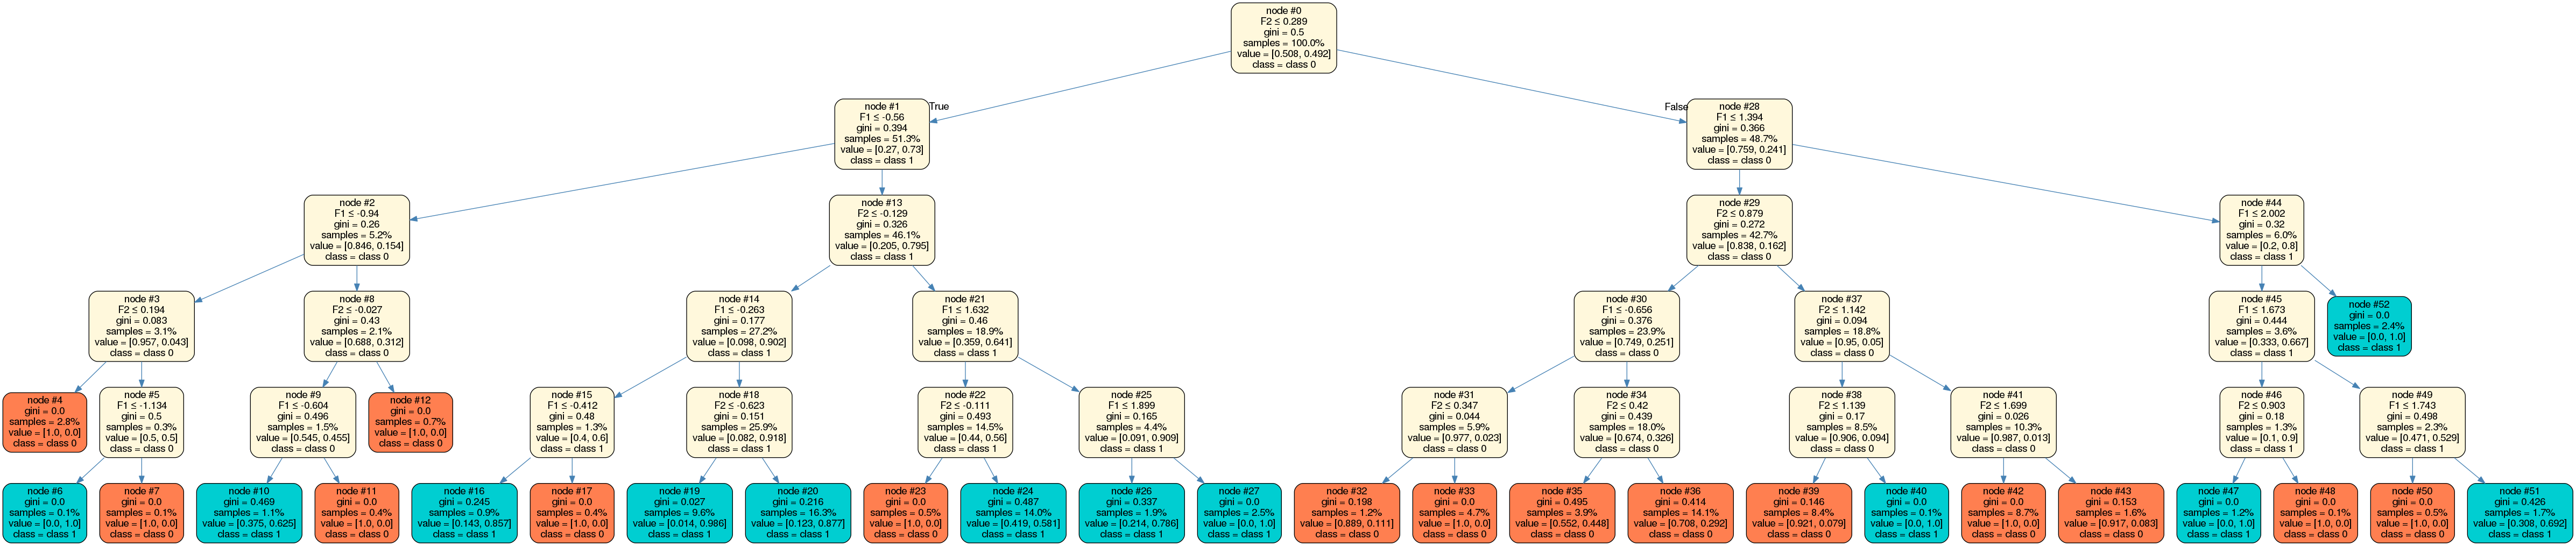

In [7]:
show_in_notebook('original_tree.png', width=1200, height=500)

## Generating explanations using Tree based Surrogates

In [8]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.util.logger import _INFO, _DEBUG

interpreter = Interpretation(X_train, feature_names=X.columns)
model_inst = InMemoryModel(classifier_est.predict, examples=X_train, model_type='classifier', unique_values=[0, 1],
                           feature_names=X.columns, target_names=target_names, log_level=_INFO)

#### 1. Using Pre-pruning

In [9]:
# 1. Learner is trained on the decisions of the base model when use_oracle=True; when 'False' original labels are used
# to learn a more interpretable tree based model.

# 2. Learner uses F1 metric as the default metric of choice for classification.
# 3. set verbose=True for more detailed information
surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, seed=5)
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='default')

2018-09-08 18:06:50,806 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-09-08 18:06:50,807 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-09-08 18:06:50,991 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750,)
2018-09-08 18:06:50,993 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.987; oracle score 0.837


-0.15

In [10]:
y_hat_train_s_pre = surrogate_explainer.predict(X_train)
y_hat_s_pre = surrogate_explainer.predict(X_test)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train_s_pre, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat_s_pre, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.85      0.80      0.82       381
    class 1       0.80      0.85      0.83       369

avg / total       0.83      0.82      0.82       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.75      0.79      0.77       119
    class 1       0.80      0.76      0.78       131

avg / total       0.78      0.78      0.78       250



2018-09-08 18:06:53,838 - skater.util.dataops - INFO - File Name: test_tree_pre.png


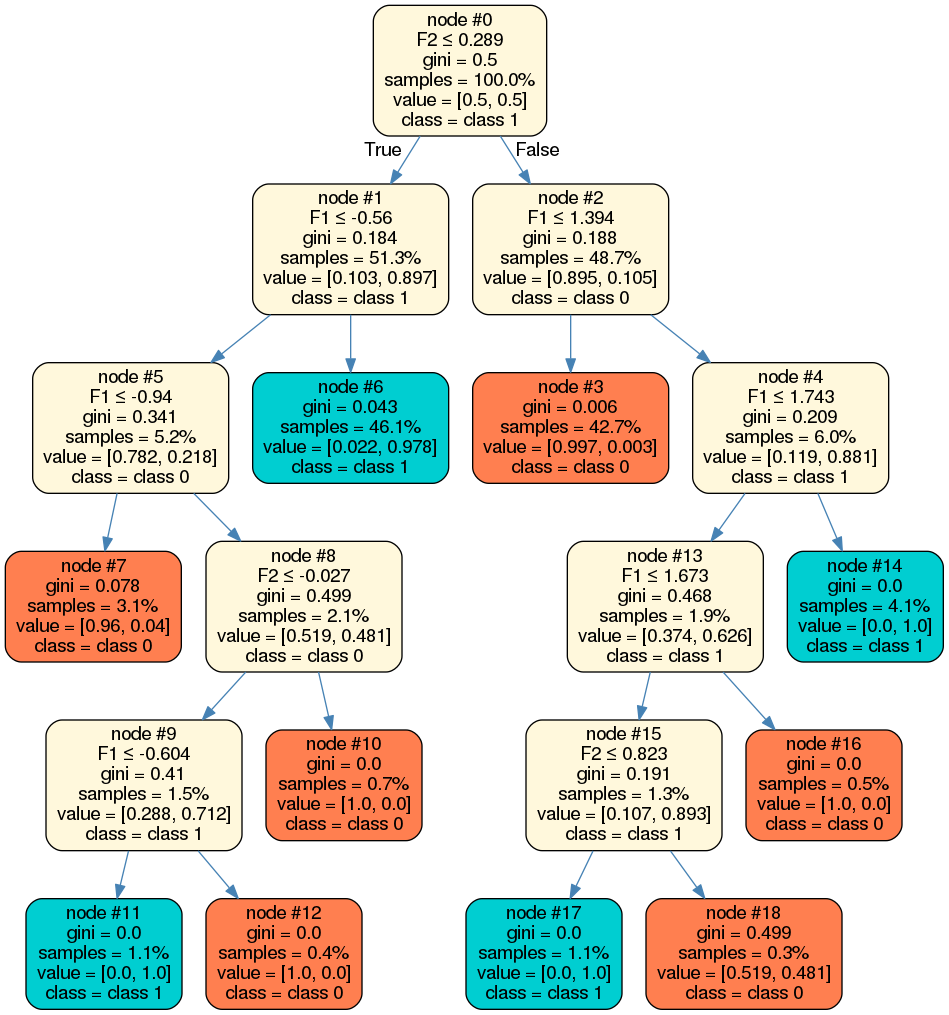

In [11]:
# Only the leaf notes(containing the respective class labels) are colored
surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_pre.png')
show_in_notebook('test_tree_pre.png', width=600, height=500)

#### 2. Post pruning

In [12]:
surrogate_explainer2 = interpreter.tree_surrogate(oracle=model_inst, seed=5)
surrogate_explainer2.fit(X_train, y_train, use_oracle=True, prune='post', verbose=False)

2018-09-08 18:06:59,117 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2018-09-08 18:06:59,121 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-09-08 18:06:59,122 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 1.0
2018-09-08 18:06:59,141 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed [3, 5, 9, 14, 15, 16]
2018-09-08 18:06:59,142 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750,)
2018-09-08 18:06:59,144 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.991; oracle score 0.837


-0.154

2018-09-08 18:07:01,153 - skater.util.dataops - INFO - File Name: test_tree_post.png


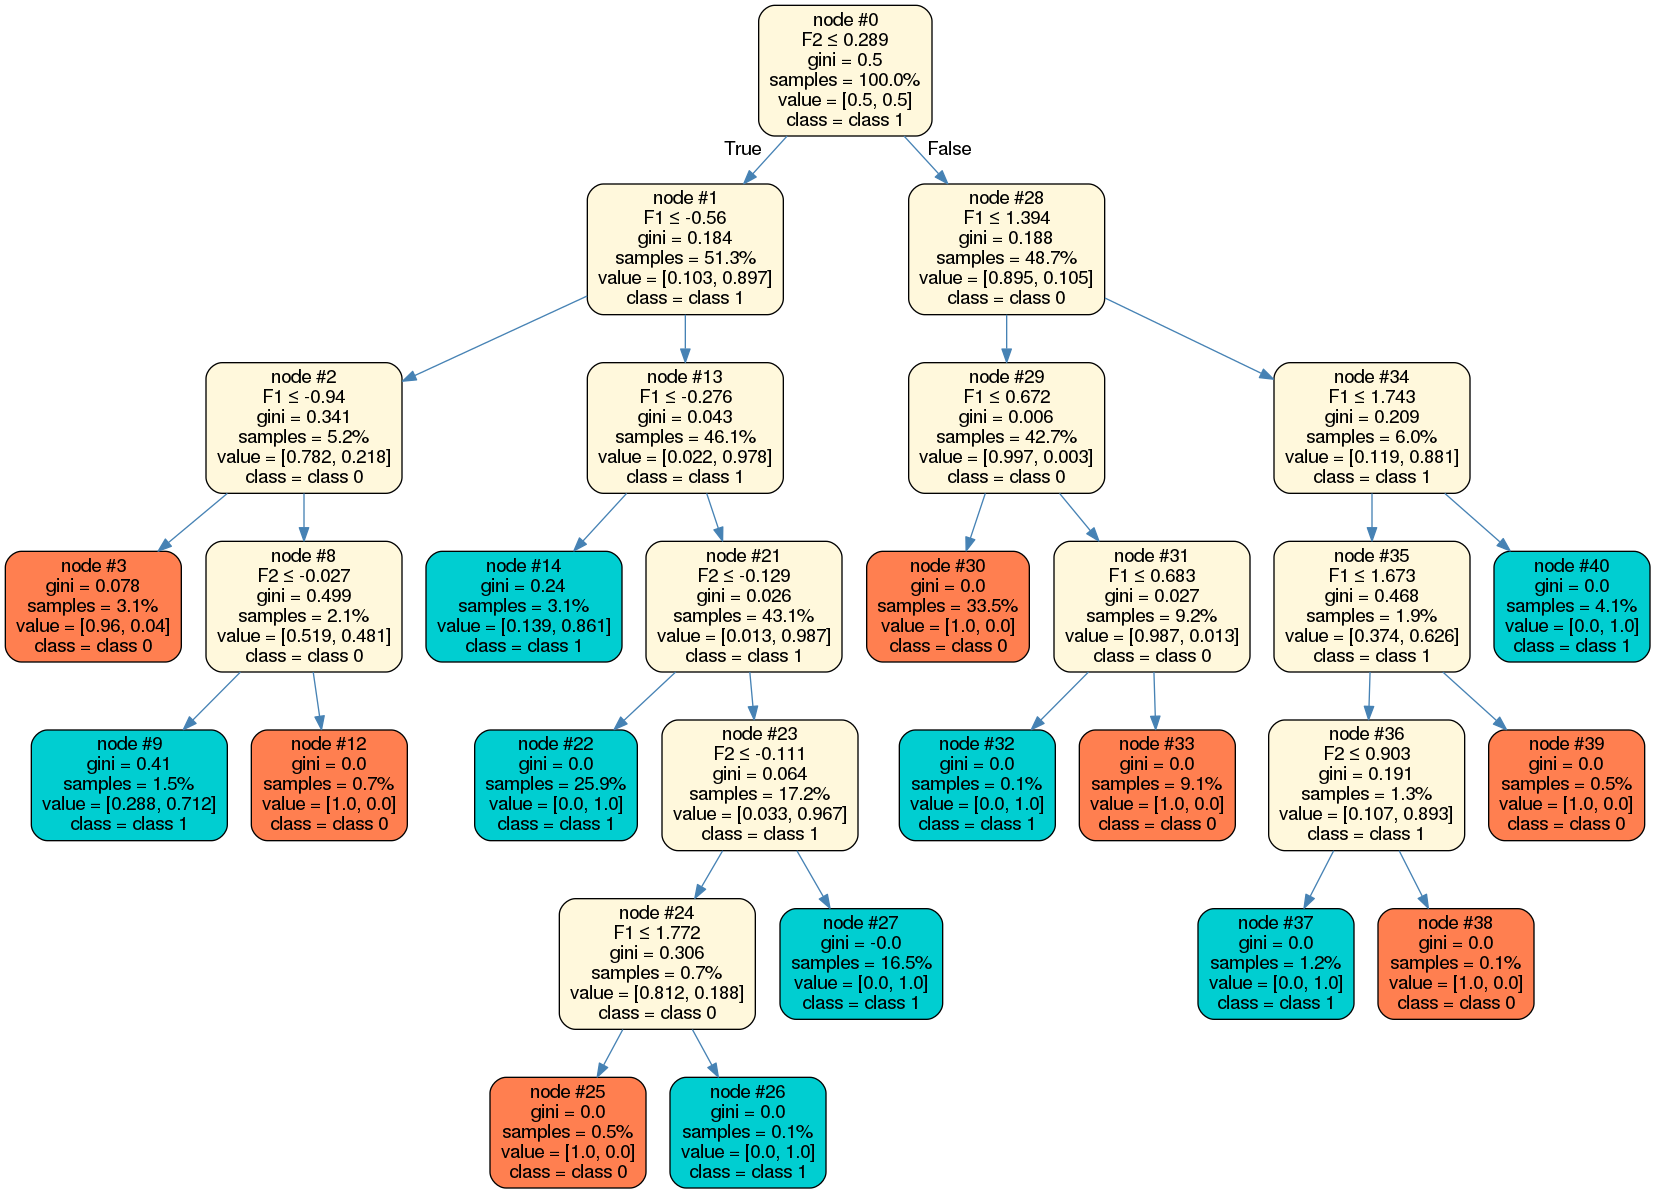

In [13]:
surrogate_explainer2.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_post.png')
show_in_notebook('test_tree_post.png', width=600, height=300)

In [14]:
y_hat_train_s_post = surrogate_explainer2.predict(X_train)
y_hat_s_post = surrogate_explainer2.predict(X_test)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train_s_post, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat_s_post, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.85      0.80      0.82       381
    class 1       0.80      0.86      0.83       369

avg / total       0.83      0.83      0.83       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.73      0.79      0.76       119
    class 1       0.79      0.73      0.76       131

avg / total       0.76      0.76      0.76       250



#### Optimizing on cross-entropy instead of F1-Score

In [15]:
interpreter = Interpretation(X_train, feature_names=X.columns)
# passing probability scoring function and setting probability to true makes the scorer chose cross-entropy(log-loss)
# as the cost function.
model_inst = InMemoryModel(classifier_est.predict_proba, examples=X_train, model_type='classifier', probability=True,
                           unique_values=[0, 1], feature_names=X.columns, target_names=target_names, 
                           log_level=_INFO)

# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, seed=5)

# either use keywords'default' or 'cross_entropy' for scorer_type
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='default')

2018-09-08 18:07:05,944 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-09-08 18:07:05,945 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
2018-09-08 18:07:06,135 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750, 2)
2018-09-08 18:07:06,138 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.334; oracle score 0.338


0.004

### 3. Building interpretable models

In [16]:
# One could also use TreeSurrogates to build Interpretable models not just surrogates
surrogate_explainer3 = interpreter.tree_surrogate(oracle=model_inst, seed=5)
surrogate_explainer3.fit(X_train, y_train, use_oracle=False, prune='pre', scorer_type='default', verbose=True)

2018-09-08 18:07:10,892 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-09-08 18:07:10,893 - skater.core.global_interpretation.tree_surrogate - DEBUG - Default search space used for CV : {'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [2, 4], 'max_leaf_nodes': [2, 4, 6, 8, 10]}
2018-09-08 18:07:10,894 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used cross-entropy
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_samples_leaf=2, max_leaf_nodes=8, max_depth=4, criterion=entropy 
[CV]  min_samples_leaf=2, max_leaf_nodes=8, max_depth=4, criterion=entropy, score=6.862114462224664, total=   0.0s
[CV] min_samples_leaf=2, max_leaf_nodes=8, max_depth=4, criterion=entropy 
[CV]  min_samples_leaf=2, max_leaf_nodes=8, max_depth=4, criterion=entropy, score=6.447312889476812, total=   0.0s
[CV] min_samples_leaf=2, max_leaf_nodes=8, max_depth=4, criterion=entropy 
[CV]  min_samples_leaf=2, max_leaf_nodes=8, max_depth=4, criterion=entropy, score=7.138120401272234, total=   0.0s
[CV] min_samples_leaf=2, max_leaf_nodes=8, max_depth=4, criterion=entropy 
[CV]  min_samples_leaf=2, max_leaf_nodes=8, max_depth=4, criterion=entropy, score=6.677592721374355, total=   0.0s
[CV] min_samples_leaf=2, max_leaf_nodes=8, max_depth=4, criterion=entropy 
[CV]  min_samples_leaf=2, max_leaf_nodes=8, max_depth=4, criterion=entropy, score=8.113237356866092, tot

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
2018-09-08 18:07:11,131 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750, 2)
2018-09-08 18:07:11,133 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.568; oracle score 0.338



[CV]  min_samples_leaf=4, max_leaf_nodes=8, max_depth=4, criterion=gini, score=6.677592721374355, total=   0.0s
[CV] min_samples_leaf=4, max_leaf_nodes=8, max_depth=4, criterion=gini 
[CV]  min_samples_leaf=4, max_leaf_nodes=8, max_depth=4, criterion=gini, score=8.113237356866092, total=   0.0s
[CV] min_samples_leaf=4, max_leaf_nodes=6, max_depth=8, criterion=gini 
[CV]  min_samples_leaf=4, max_leaf_nodes=6, max_depth=8, criterion=gini, score=6.862114462224664, total=   0.0s
[CV] min_samples_leaf=4, max_leaf_nodes=6, max_depth=8, criterion=gini 
[CV]  min_samples_leaf=4, max_leaf_nodes=6, max_depth=8, criterion=gini, score=5.756521369629995, total=   0.0s
[CV] min_samples_leaf=4, max_leaf_nodes=6, max_depth=8, criterion=gini 
[CV]  min_samples_leaf=4, max_leaf_nodes=6, max_depth=8, criterion=gini, score=7.368373579922104, total=   0.0s
[CV] min_samples_leaf=4, max_leaf_nodes=6, max_depth=8, criterion=gini 
[CV]  min_samples_leaf=4, max_leaf_nodes=6, max_depth=8, criterion=gini, score=

-0.23

In [17]:
y_hat_train_s_i = surrogate_explainer3.predict(X_train)
y_hat_s_i = surrogate_explainer3.predict(X_test)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train_s_i, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat_s_i, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.76      0.73      0.74       381
    class 1       0.73      0.76      0.75       369

avg / total       0.74      0.74      0.74       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.68      0.74      0.71       119
    class 1       0.74      0.68      0.71       131

avg / total       0.71      0.71      0.71       250



2018-09-08 18:07:14,246 - skater.util.dataops - INFO - File Name: test_tree_interpretable.png


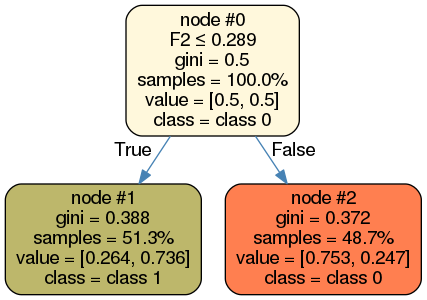

In [18]:
surrogate_explainer3.plot_global_decisions(colors=['coral', 'darkkhaki'], 
                                          file_name='test_tree_interpretable.png')
show_in_notebook('test_tree_interpretable.png', width=300, height=300)